In [34]:
import pandas as pd
import numpy as np
matches=pd.read_csv(r'/Users/aaknight/Downloads/england-premier-league-matches-2018-to-2019-stats.csv')
matches['discrep']=matches['home_team_goal_count']-matches['away_team_goal_count']
winners=[]
for i in range(matches['discrep'].shape[0]):
    if matches['discrep'][i]>0:
        winners+=['home']
    if matches['discrep'][i]<0:
        winners+=['away']
    if matches['discrep'][i]==0:
        winners+=['draw'] #when to predict draws?
matches['winners']=winners
#as an initial approach trying to predict the difference in goals in the match
test=pd.DataFrame(matches.iloc[-20:-1,:])
train=pd.DataFrame(matches.iloc[:-20,:])

In [12]:
blep=train.pivot('home_team_name','away_team_name','discrep')

<AxesSubplot:xlabel='away_team_name', ylabel='home_team_name'>

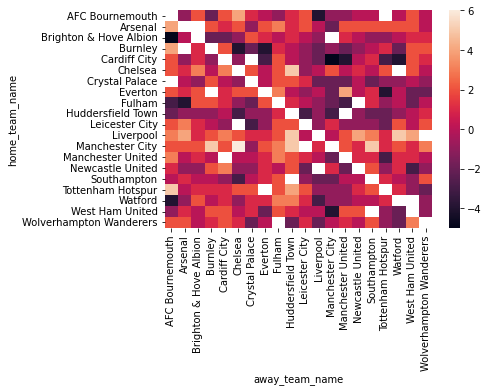

In [13]:
import seaborn as sns
sns.heatmap(blep)

In [14]:
mean_discrep_home=blep.mean(axis=1)
mean_discrep_away=blep.mean(axis=0)

In [15]:
match_discrep=[]
for i in range(train.shape[0]):
    home_team_name=train['home_team_name'][i]
    away_team_name=train['away_team_name'][i]
    match_discrep+=[mean_discrep_home[home_team_name]-mean_discrep_home[away_team_name]]

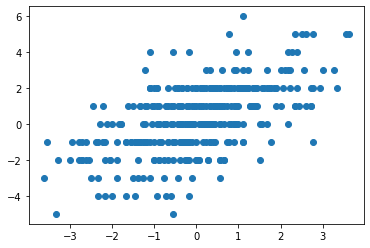

In [16]:
import matplotlib.pyplot as plt
plt.scatter(x=match_discrep,y=train['discrep']) #not bad


In [17]:
winners_pred=[]
for i in range(train['discrep'].shape[0]):
    if match_discrep[i]>0.1:
        winners_pred+=['home']
    if match_discrep[i]<-0.1:
        winners_pred+=['away']
    if match_discrep[i]<0.1 and match_discrep[i]>-0.1:
        winners_pred+=['draw'] #when to predict draws?

In [18]:
train['winners_pred']=winners_pred
train['match_pred_discrep']=match_discrep
train['pred_nonpred_diff']=train['discrep']-match_discrep


In [19]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(y=train.columns,x=train.columns)
def h(y='match_pred_discrep',x='match_pred_discrep'):
    sns.scatterplot(x=x,y=y,data=train,alpha=0.15)

interactive(children=(Dropdown(description='y', index=67, options=('timestamp', 'date_GMT', 'status', 'attenda…

In [20]:
#the differences from the predicted discrepancy seem to be linearly related to the home team possession in the match...
#that's not observable pre-match, average possession values would be though.


In [21]:
#subsetting data for trueskill mithering

trueskill_subset=train[['home_team_name','away_team_name','winners']]
trueskill_subset['home_team_name'].unique()


array(['Manchester United', 'Newcastle United', 'AFC Bournemouth',
       'Fulham', 'Huddersfield Town', 'Watford',
       'Wolverhampton Wanderers', 'Liverpool', 'Southampton', 'Arsenal',
       'Cardiff City', 'Everton', 'Leicester City', 'Tottenham Hotspur',
       'West Ham United', 'Chelsea', 'Burnley', 'Manchester City',
       'Brighton & Hove Albion', 'Crystal Palace'], dtype=object)

In [29]:
import math
import trueskill
from trueskill import Rating, rate_1vs1, quality_1vs1

class game_sequence:
    #this takes the home team name, away team name and winners columns and computes trueskill rankings
    def __init__(self,trueskill_subset):
        self.trueskill_subset=trueskill_subset
        self.ratings_names=trueskill_subset['home_team_name'].unique()
        self.ratings_objects={}        
        for i in self.ratings_names:
            self.ratings_objects[i]=Rating() #these are initialisations, they become more reliable for team x (assuming constant skill and conditions) as more games involving x are played
    
    def play_season(self):
        #this updates the skills using the trueskill rating system
        for i in list(self.trueskill_subset.iterrows()):
            home_team_name=i[1]['home_team_name']
            away_team_name=i[1]['away_team_name']
            if i[1]['winners']=='home':
                self.ratings_objects[home_team_name],self.ratings_objects[away_team_name]=rate_1vs1(self.ratings_objects[home_team_name], self.ratings_objects[away_team_name])
            if i[1]['winners']=='away':
                self.ratings_objects[away_team_name],self.ratings_objects[home_team_name]=rate_1vs1(self.ratings_objects[away_team_name], self.ratings_objects[home_team_name])
            if i[1]['winners']=='draw':
                self.ratings_objects[home_team_name],self.ratings_objects[away_team_name]=rate_1vs1(self.ratings_objects[home_team_name], self.ratings_objects[away_team_name],drawn=True)
            
    def prob_draw(self,name1,name2):
        #computes draw probability using trueskill's calculator
        return quality_1vs1(self.ratings_objects[name1],self.ratings_objects[name2]) #this is drawn from a different distribution than wins/losses, i guess it would be a better predictor of whether the game is 'tight' or not
    
    def prob_win(self,name1, name2):
        #computes win probability using definitions of quantities, this isn't with reference
        #to trueskill's draw probability, so (win+loss+draw != 1)
        delta_mu = self.ratings_objects[name1].mu - self.ratings_objects[name2].mu
        sum_sigma = self.ratings_objects[name1].sigma**2 + self.ratings_objects[name2].sigma**2
        size = 2
        denom = math.sqrt(size * sum_sigma)
        ts = trueskill.global_env()
        return ts.cdf(delta_mu / denom)

    def prob_loss(self,name1,name2):
        win_prob=self.prob_win(name1,name2)
        loss_prob=1-(win_prob)
        return loss_prob
    
    def prob_predict(self,name1,name2):
        toreturn={}
        toreturn["home"]=self.prob_win(name1,name2)
        toreturn['draw']=self.prob_draw(name1,name2)
        toreturn['away']=self.prob_loss(name1,name2)
        return toreturn

In [30]:
trueskills=game_sequence(trueskill_subset)
trueskills.play_season()

In [31]:
trueskill_preds_test=[trueskills.prob_predict(test['home_team_name'].iloc[i],test['away_team_name'].iloc[i]) for i in range(test.shape[0])]
argmax_preds_test=[max(i,key=i.get) for i in trueskill_preds_test]


In [32]:
from sklearn.metrics import confusion_matrix
trueskill_confusion=confusion_matrix(test['winners'],argmax_preds_test)
pd.DataFrame(trueskill_confusion,index=['home','draw','away'],columns=['home','draw','away'])
#predicts home victories okay maybe, away and draw not so much
#maybe a useful feature for a larger predictor

,home,draw,away
home,5,0,1
draw,1,2,2
away,1,3,4


In [33]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Jan  2 16:21:00 2022

@author: dewiballard
"""

import pandas as pd
import numpy as np
import seaborn as sns

# Create column listing goal difference
matches['goal_diff']=matches['home_team_goal_count']-matches['away_team_goal_count']

# Create column listing away or home win
conditions = [
    (matches['goal_diff'] == 0),
    (matches['goal_diff'] > 0),
    (matches['goal_diff'] < 0)]
choices = ['draw', 'home win', 'away win']
matches['result'] = np.select(conditions,choices, default=0)

# Create column listing winner name
conditions = [
    (matches['result'] == 'draw'),
    (matches['result'] == 'home win'),
    (matches['result'] == 'away win')]
choices = ['no winner', matches['home_team_name'], matches['away_team_name']]
matches['winner'] = np.select(conditions,choices, default=0)

# Create column listing home team form
matches['home_team_form'] = np.nan
for column, row in matches.iterrows(): #predict win/draw/lose
    home_form = matches.loc[:row.name]
    home_form = home_form.loc[home_form['home_team_name']==row['home_team_name']]
    home_form = home_form[-6:-1] #only looking at last 5 games
    form_string = ''
    for column2, row2 in home_form.iterrows():
        if row2['winner'] == row2['home_team_name']:
            form_string = form_string + 'W'
        elif row2['winner'] == 'no winner':
            form_string = form_string + 'D'
        else:
            form_string = form_string + 'L'
    matches.loc[row.name, 'home_team_form'] = form_string

# Create column listing away team form
matches['away_team_form'] = np.nan
for column, row in matches.iterrows(): #predict win/draw/lose
    away_form = matches.loc[:row.name]
    away_form = away_form.loc[away_form['away_team_name']==row['away_team_name']]
    away_form = away_form[-6:-1] #only looking at last 5 games
    form_string = ''
    for column2, row2 in away_form.iterrows():
        if row2['winner'] == row2['away_team_name']:
            form_string = form_string + 'W'
        elif row2['winner'] == 'no winner':
            form_string = form_string + 'D'
        else:
            form_string = form_string + 'L'
    matches.loc[row.name, 'away_team_form'] = form_string

#calculate 'score' for team based on form (W is 3 points, D is 1, L is 0). 
for column, row in matches.iterrows():
    matches2 = matches.loc[row.name-1:row.name]
    for i in matches2['home_team_form'].astype(str):
        home_score = 0
        for char in i:
            if char == 'W':
                home_score = home_score + 3
            if char == 'D':
                home_score = home_score + 1
            else:
                home_score = home_score
    for i in matches2['away_team_form'].astype(str):
        away_score = 0
        for char in i:
            if char == 'W':
                away_score = away_score + 3
            if char == 'D':
                away_score = away_score + 1
            else:
                home_score = home_score
    matches.loc[row.name, 'home_score'] = home_score
    matches.loc[row.name, 'away_score'] = away_score
    matches.loc[row.name, 'likelihood_home_win'] = home_score - away_score #more positive = more chance home win

print(matches.tail(20))

      timestamp               date_GMT    status  attendance  \
360  1556910000   May 03 2019 - 7:00pm  complete       39303   
361  1556969400  May 04 2019 - 11:30am  complete       10630   
362  1556978400   May 04 2019 - 2:00pm  complete       59961   
363  1556978400   May 04 2019 - 2:00pm  complete       30456   
364  1556987400   May 04 2019 - 4:30pm  complete       32133   
365  1556995500   May 04 2019 - 6:45pm  complete       52206   
366  1557061200   May 05 2019 - 1:00pm  complete       40650   
367  1557061200   May 05 2019 - 1:00pm  complete       24263   
368  1557070200   May 05 2019 - 3:30pm  complete       59965   
369  1557169200   May 06 2019 - 7:00pm  complete       54506   
370  1557669600   May 12 2019 - 2:00pm  complete       30662   
371  1557669600   May 12 2019 - 2:00pm  complete       21461   
372  1557669600   May 12 2019 - 2:00pm  complete       25433   
373  1557669600   May 12 2019 - 2:00pm  complete       24979   
374  1557669600   May 12 2019 - 2:00pm  

In [111]:
class who_won_form:
    
    def __init__(self, frame):
        self.frame=pd.DataFrame(frame)
    
    def make_who_won(self):
        n=self.frame.shape[0]
        storage=[]
        for index, row in self.frame.iterrows():
            if row['winners']=="home":
                storage.append(row['home_team_name'])
            if row['winners']=='away':
                storage.append(row['away_team_name'])
            if row['winners']=='draw':
                storage.append('draw')
            
        
        self.frame['winner_name']=storage
        self.frame['who_played']=self.frame['home_team_name']+self.frame['away_team_name']
    
    def winner_code(self,i,team_name):
        toreturn=""
        if i==team_name:
            toreturn='W'
        else:
            if i=='draw':
                toreturn='D'
            else:
                toreturn='L'
        return toreturn
    
        
    def construct_form_series(self, team_name):
        tempframe=pd.DataFrame(self.frame)
        tempframe['team_name_in']=tempframe['who_played'].transform(func=lambda x: team_name in x, axis=0)
        team_name_series=tempframe['winner_name'][tempframe['team_name_in']] #selects games played as series
        overall_series=team_name_series.transform(func= axis=0)
        home_indicator=tempframe['home_team_name']==team_name
        home_series=overall_series[home_indicator]
        away_series=overall_series[home_indicator.transform(func = lambda x: not x, axis=0)]
#         return overall_series, home_series, away_series
        print(team_name_series)
        

In [112]:
whowon=who_won_form(train)
whowon.make_who_won()
whowon.construct_form_series('Manchester_United')

Series([], Name: winner_name, dtype: object)


In [92]:
whowon.frame['winner_name'][whowon.frame['home_team_name'].transform(func=lambda x: 'Manchester United' in x, axis=0)]

0      Manchester United
29     Tottenham Hotspur
56                  draw
76     Manchester United
98     Manchester United
123                 draw
148                 draw
154    Manchester United
185    Manchester United
199    Manchester United
223    Manchester United
234                 draw
268                 draw
283    Manchester United
309    Manchester United
331    Manchester United
349      Manchester City
359                 draw
Name: winner_name, dtype: object